In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tqdm.notebook import tqdm

In [2]:
# Configs
BASE_PATH = '/Users/AnshulSrivastava/Desktop/Fall24/CMSE 492/Project/isic-2024-challenge/'
RANDOM_SEED = 42
N_FOLDS = 5
maj_frac = 0.1
min_frac = 10

In [3]:
# set random seed
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [4]:
# Check if GPU is available
print("GPU", "available (YES!)" if tf.config.list_physical_devices('GPU') else "not available :(")

# If GPU is available, use it
if tf.config.list_physical_devices('GPU'):
    device = '/GPU:0'
else:
    device = '/CPU:0'

print(device)

GPU not available :(
/CPU:0


In [5]:
# Load the data
train_metadata = pd.read_csv(f'{BASE_PATH}/train_processed.csv')

In [6]:
# Sample the data to have a balanced dataset
maj_class = train_metadata[train_metadata['target'] == 0]
min_class = train_metadata[train_metadata['target'] == 1]

maj_class_sample = maj_class.sample(frac=maj_frac, random_state=RANDOM_SEED)
min_class_sample = min_class.sample(frac=min_frac, random_state=RANDOM_SEED, replace=True)

train_metadata_sample = pd.concat([maj_class_sample,
                                      min_class_sample]).sample(frac=1, random_state=RANDOM_SEED)

In [7]:
# Add class weights
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight('balanced', classes=np.unique(train_metadata_sample['target']), 
                                     y=train_metadata_sample['target'])
class_weights = dict(enumerate(class_weights))
print("Class Weights:", class_weights)

Class Weights: {0: 0.5490428532208551, 1: 5.597582697201018}


In [8]:
# Visualize first image
from PIL import Image
import matplotlib.pyplot as plt
import h5py
import io

train_val_img = h5py.File(f'{BASE_PATH}/train-image.hdf5', 'r')
test_img = h5py.File(f'{BASE_PATH}/test-image.hdf5', 'r')

In [9]:
# Define the Data Generator
import random
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
import os

class TrainDataLoader:
    def __init__(self, hdf5_file, metadata_df, benign_indices, malignant_indices, batch_size=32, augment=False):
        self.hdf5_file = hdf5_file
        self.metadata_df = metadata_df.reset_index(drop=True)
        self.benign_indices = list(benign_indices)
        self.malignant_indices = list(malignant_indices)
        self.batch_size = batch_size
        self.augment = augment
        
        if self.augment:
            # Define a more complex augmentation pipeline
            self.augmenter = ImageDataGenerator(
                rotation_range=30,
                width_shift_range=0.1,
                height_shift_range=0.1,
                shear_range=0.1,
                zoom_range=0.1,
                horizontal_flip=True,
                vertical_flip=True,
                fill_mode='nearest',
                brightness_range=[0.8, 1.2],
                preprocessing_function=self.add_gaussian_noise,
                )
        else:
            self.augmenter = None  # No augmentation during validation

    def __len__(self):
        # Calculate the number of batches per epoch
        return int(np.floor(len(self.benign_indices) / (self.batch_size // 2)))

    def __getitem__(self, idx):
        half_batch_size = self.batch_size // 2

        # Sample indices
        benign_sampled_indices = random.sample(self.benign_indices, half_batch_size)
        malignant_sampled_indices = random.choices(self.malignant_indices, k=half_batch_size)

        images = []
        labels = []
        #isic_ids = []

        # Load benign images
        for idx in benign_sampled_indices:
            isic_id = self.metadata_df.iloc[idx]['isic_id']
            img = self.load_image(isic_id)
            if self.augmenter:
                img = self.augmenter.random_transform(img)
            images.append(img)
            labels.append(0)
            #isic_ids.append(isic_id)

        # Load and augment malignant images
        for idx in malignant_sampled_indices:
            isic_id = self.metadata_df.iloc[idx]['isic_id']
            img = self.load_image(isic_id)
            if self.augmenter:
                img = self.augmenter.random_transform(img)
            images.append(img)
            labels.append(1)
            #isic_ids.append(isic_id)

        # Shuffle the batch
        combined = list(zip(images, labels))
        random.shuffle(combined)
        images, labels = zip(*combined)
        
        # Convert to arrays
        images = np.array(images)
        labels = np.array(labels)
        #isic_ids = np.array(isic_ids)

        return images, labels

    def load_image(self, isic_id):
        # Retrieve image from HDF5 and preprocess
        byte_string = self.hdf5_file[isic_id][()]
        nparr = np.frombuffer(byte_string, np.uint8)
        img = Image.open(io.BytesIO(nparr))
        img = img.resize((128, 128))
        img = preprocess_input(np.array(img))
        return img
        
    def add_gaussian_noise(self, img):
        mean = 0.0  # Mean of Gaussian noise
        stddev = 0.1  # Standard deviation of Gaussian noise
        noise = np.random.normal(mean, stddev, img.shape)  # Generate noise
        img = img + noise  # Add noise to the image
        img = np.clip(img, 0., 1.)  # Clip to ensure values remain in [0, 1] range
        return img

    def on_epoch_end(self):
        # Optionally shuffle indices
        random.shuffle(self.benign_indices)
        random.shuffle(self.malignant_indices)

class ValidationDataLoader:
    def __init__(self, hdf5_file, metadata_df, batch_size=32, min_positive_samples=5):
        self.hdf5_file = hdf5_file
        self.metadata_df = metadata_df.reset_index(drop=True)
        self.batch_size = batch_size
        self.benign_indices = metadata_df[metadata_df['target'] == 0].index.tolist()
        self.malignant_indices = metadata_df[metadata_df['target'] == 1].index.tolist()
        self.min_positive_samples = min_positive_samples

    def __len__(self):
        return len(self.metadata_df) // self.batch_size

    def __getitem__(self, idx):
        actual_batch_size = min(self.batch_size, len(self.metadata_df) - idx * self.batch_size)
        # Skip this batch if it's not complete
        if actual_batch_size < self.batch_size:
            raise StopIteration("Incomplete batch skipped")

        # Calculate the proportion of positive samples in the dataset
        positive_ratio = len(self.malignant_indices) / len(self.metadata_df)

        # Calculate the number of positive samples for this batch
        num_positive_samples = max(self.min_positive_samples, int(actual_batch_size * positive_ratio))
        num_positive_samples = min(num_positive_samples, len(self.malignant_indices))  # Ensure it doesn't exceed available positives

        # Calculate the remaining samples as negative
        num_negative_samples = actual_batch_size - num_positive_samples
        num_negative_samples = min(num_negative_samples, len(self.benign_indices))  # Ensure it doesn't exceed available negatives

        # Sample indices
        positive_sample_indices = random.sample(self.malignant_indices, num_positive_samples)
        negative_sample_indices = random.sample(self.benign_indices, num_negative_samples)

        # Combine and shuffle
        batch_indices = positive_sample_indices + negative_sample_indices
        random.shuffle(batch_indices)
        
        images, labels = [], []

        for index in batch_indices:
            isic_id = self.metadata_df.iloc[index]['isic_id']
            img = self.load_image(isic_id)
            label = self.metadata_df.iloc[index]['target']
            images.append(img)
            labels.append(label)

        # Convert to numpy arrays
        images = np.array(images)
        labels = np.array(labels)

        return images, labels

    def load_image(self, isic_id):
        byte_string = self.hdf5_file[isic_id][()]
        nparr = np.frombuffer(byte_string, np.uint8)
        img = Image.open(io.BytesIO(nparr))
        img = img.resize((128, 128))
        img = preprocess_input(np.array(img))
        return img
    
    def on_epoch_end(self):
        # Shuffle benign and malignant indices after each epoch
        random.shuffle(self.benign_indices)
        random.shuffle(self.malignant_indices)

class TestDataLoader:
    def __init__(self, hdf5_file, metadata_df, batch_size=32):
        self.hdf5_file = hdf5_file
        self.metadata_df = metadata_df.reset_index(drop=True)
        self.batch_size = batch_size

    def __len__(self):
        # Number of full batches
        return (len(self.metadata_df) + self.batch_size - 1) // self.batch_size

    def __getitem__(self, idx):
        start_idx = idx * self.batch_size
        end_idx = start_idx + self.batch_size
        # If the end index exceeds the data length, adjust it for the last batch
        batch_indices = range(start_idx, min(end_idx, len(self.metadata_df)))
        
        images = []
        for index in batch_indices:
            isic_id = self.metadata_df.iloc[index]['isic_id']
            img = self.load_image(isic_id)
            images.append(img)

        return np.array(images)

    def load_image(self, isic_id):
        byte_string = self.hdf5_file[isic_id][()]
        nparr = np.frombuffer(byte_string, np.uint8)
        img = Image.open(io.BytesIO(nparr))
        img = img.resize((128, 128))
        img = preprocess_input(np.array(img))
        return img

    def __iter__(self):
        for i in range(len(self)):
            yield self[i]

In [10]:
# Define custom metric
from sklearn.metrics import roc_auc_score

def partial_auc_metric(y_true, y_pred):
    def compute_partial_auc(y_true, y_pred):
        # Convert tensors to numpy arrays
        y_true_np = y_true.numpy()
        y_pred_np = y_pred.numpy()

        # Compute partial AUC as per your custom function
        min_tpr = 0.80
        max_fpr = abs(1 - min_tpr)
        
        v_gt = abs(y_true_np - 1)
        v_pred = np.array([1.0 - x for x in y_pred_np])
        
        partial_auc_scaled = roc_auc_score(v_gt, v_pred, max_fpr=max_fpr)
        partial_auc = 0.5 * max_fpr**2 + (max_fpr - 0.5 * max_fpr**2) / (1.0 - 0.5) * (partial_auc_scaled - 0.5)
        
        return partial_auc

    # Wrap the custom Python function with tf.py_function
    result = tf.py_function(func=compute_partial_auc, inp=[y_true, y_pred], Tout=tf.float32)
    
    return result

# Define function to set learning rate schedule
def get_lr_scheduler(initial_learning_rate, steps_per_epoch, epochs_per_restart):
    # Calculate the first decay steps
    first_decay_steps = steps_per_epoch * epochs_per_restart
    
    # Define the learning rate scheduler
    lr_schedule = tf.keras.optimizers.schedules.CosineDecayRestarts(
        initial_learning_rate=initial_learning_rate,
        first_decay_steps=first_decay_steps,
        t_mul=2.0,   # Increases decay steps after each restart (e.g., 5, 10, 20 epochs)
        m_mul=1.0,   # Keeps max learning rate constant at each restart
        alpha=0.0    # Minimum learning rate as a fraction of initial rate
    )
    
    return lr_schedule

In [11]:
# Define the model
from tensorflow.keras.applications import mobilenet_v2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras import models, layers

def build_model():
    # Load the pre-trained model
    base_model = mobilenet_v2.MobileNetV2(input_shape=(128, 128, 3), include_top=False, weights='imagenet')

    # Freeze the base model
    base_model.trainable = False

    # Start building your custom model
    model = models.Sequential()

    # Add the EfficientNetB0 as the base
    model.add(base_model)

    # Add a global average pooling layer to reduce dimensionality
    model.add(layers.GlobalAveragePooling2D())

    # Add a dense layer with ReLU activation
    model.add(layers.Dense(512, activation='relu', kernel_initializer='he_normal'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.4))  # Dropout for regularization

    # Another dense layer for more learning capacity
    model.add(layers.Dense(256, activation='relu', kernel_initializer='he_normal'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.5))

    # Final output layer for binary classification (sigmoid activation for binary classification)
    model.add(layers.Dense(1, activation='sigmoid'))

    return model

In [12]:
# Perform Stratified K-Fold
from sklearn.model_selection import StratifiedGroupKFold

def stratified_group_k_fold(train_metadata_sample, N_FOLDS, RANDOM_SEED, f):

    train_metadata_sample = train_metadata_sample.reset_index(drop=True)
    train_metadata_sample['kfold'] = -1

    sgkf = StratifiedGroupKFold(n_splits=N_FOLDS, random_state=RANDOM_SEED, shuffle=True)

    for fold, (train_idx, val_idx) in enumerate(sgkf.split(X=train_metadata_sample, y=train_metadata_sample['target'], 
                                                        groups=train_metadata_sample['patient_id'])):
        train_metadata_sample.loc[val_idx, 'kfold'] = fold

    training_df = train_metadata_sample[train_metadata_sample['kfold'] != f]
    validation_df = train_metadata_sample[train_metadata_sample['kfold'] == f]

    training_df = training_df.reset_index(drop=True)
    validation_df = validation_df.reset_index(drop=True)

    return training_df, validation_df

In [13]:
# Define training histories
fold1_histories = {'accuracy': [], 'val_accuracy': [], 'partial_auc_metric': [], 'val_partial_auc_metric': []}
fold2_histories = {'accuracy': [], 'val_accuracy': [], 'partial_auc_metric': [], 'val_partial_auc_metric': []}
fold3_histories = {'accuracy': [], 'val_accuracy': [], 'partial_auc_metric': [], 'val_partial_auc_metric': []}
fold4_histories = {'accuracy': [], 'val_accuracy': [], 'partial_auc_metric': [], 'val_partial_auc_metric': []}
fold5_histories = {'accuracy': [], 'val_accuracy': [], 'partial_auc_metric': [], 'val_partial_auc_metric': []}

# Phase 1 (OOF for fold 0)

In [14]:
# Perform K-Fold, Setting f=0
f = 0
training_df, validation_df = stratified_group_k_fold(train_metadata_sample, N_FOLDS, RANDOM_SEED, f)

# Class Distribution in Training and Validation Data
print('Class Distribution in Training Data:')
display(training_df['target'].value_counts())

print('Class Distribution in Validation Data:')
display(validation_df['target'].value_counts())

Class Distribution in Training Data:


target
0    30039
1     3071
Name: count, dtype: int64

Class Distribution in Validation Data:


target
0    10028
1      859
Name: count, dtype: int64

In [15]:
# Define the data loaders
train_loader = TrainDataLoader(train_val_img, training_df, training_df[training_df['target'] == 0].index, 
                                training_df[training_df['target'] == 1].index, batch_size=32, augment=True)

val_loader = ValidationDataLoader(train_val_img, validation_df, batch_size=32, min_positive_samples=5)

# Define training and validation datasets
train_dataset = tf.data.Dataset.from_generator(
    lambda: train_loader,
    output_signature=(
        tf.TensorSpec(shape=(32, 128, 128, 3), dtype=tf.float32),  # Adjust shape based on batch size and image size
        tf.TensorSpec(shape=(32,), dtype=tf.int32)
    )
)

# Repeat for validation loader
val_dataset = tf.data.Dataset.from_generator(
    lambda: val_loader,
    output_signature=(
        tf.TensorSpec(shape=(32, 128, 128, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(32,), dtype=tf.int32)
    )
)

In [16]:
tf.keras.backend.clear_session()

# Build the model
model = build_model()

# Define Learning Rate Scheduler
initial_learning_rate = 1e-3
steps_per_epoch = len(train_loader)  # Total number of batches in the training set

lr_schedule = get_lr_scheduler(initial_learning_rate, steps_per_epoch, epochs_per_restart=5)
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=lr_schedule)

# Define Callbacks
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Define the checkpoint callback
checkpoint_callback = ModelCheckpoint(
    filepath='Fold1/checkpoints/model_{epoch:02d}.h5',  # Save a new file for each epoch
    save_weights_only=False,      # Save the entire model
    save_best_only=True,        # Save only the best model
    monitor='val_partial_auc_metric',  # Use the custom validation AUC metric
    mode='max',                 # Maximizing the AUC
    verbose=0
)

# Define the early stopping callback based on validation partial AUC
early_stopping_callback = EarlyStopping(
    monitor='val_partial_auc_metric',  # Monitor the custom validation AUC metric
    patience=5,                        # Number of epochs with no improvement before stopping
    mode='max',                        # Maximize the AUC
    min_delta=0.001,                   # Minimum change in the monitored quantity
    restore_best_weights=True,         # Restore the best weights after stopping
    verbose=1
)

# Compile the model
model.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=['accuracy', partial_auc_metric]
)

# Define callbacks
callbacks = [checkpoint_callback, early_stopping_callback]

In [17]:
# Train the model
history1 = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=30,
    steps_per_epoch=len(train_loader),
    validation_steps=len(val_loader),
    callbacks=callbacks
    )

Epoch 1/30


2024-11-11 13:18:45.609568: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-11-11 13:18:45.622059: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


1877/1877 [==============================] - ETA: 0s - loss: 0.4348 - accuracy: 0.8028 - partial_auc_metric: 0.1280

2024-11-11 13:22:53.735946: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


1877/1877 [==============================] - 281s 149ms/step - loss: 0.4348 - accuracy: 0.8028 - partial_auc_metric: 0.1280 - val_loss: 0.3749 - val_accuracy: 0.8267 - val_partial_auc_metric: 0.1176
Epoch 2/30
1877/1877 [==============================] - 276s 147ms/step - loss: 0.3481 - accuracy: 0.8466 - partial_auc_metric: 0.1488 - val_loss: 0.3623 - val_accuracy: 0.8473 - val_partial_auc_metric: 0.1094
Epoch 3/30
1877/1877 [==============================] - 269s 143ms/step - loss: 0.3144 - accuracy: 0.8645 - partial_auc_metric: 0.1578 - val_loss: 0.3759 - val_accuracy: 0.8400 - val_partial_auc_metric: 0.1178
Epoch 4/30
1877/1877 [==============================] - 281s 150ms/step - loss: 0.2784 - accuracy: 0.8819 - partial_auc_metric: 0.1654 - val_loss: 0.3835 - val_accuracy: 0.8461 - val_partial_auc_metric: 0.1166
Epoch 5/30
1877/1877 [==============================] - 278s 148ms/step - loss: 0.2624 - accuracy: 0.8906 - partial_auc_metric: 0.1688 - val_loss: 0.3915 - val_accuracy: 0

In [18]:
# Save the training history
for key in fold1_histories.keys():
    fold1_histories[key].extend(history1.history[key])

In [22]:
from tensorflow.keras.regularizers import l2

# Set the number of layers to unfreeze
num_layers_to_unfreeze = 30

# Get the total number of layers in the base model
total_layers = len(model.layers[0].layers)

# Unfreeze the last `num_layers_to_unfreeze` layers of the EfficientNet base model
for layer in model.layers[0].layers[-num_layers_to_unfreeze:]:
    layer.trainable = True
    if hasattr(layer, 'kernel_regularizer'):
        layer.kernel_regularizer = l2(1e-4)

# Updated Learning Rate Scheduler for Fine-Tuning
initial_learning_rate = 5e-5  # Lower than the initial phase
epochs_per_restart = 5  # Shorter restart cycle

lr_schedule = get_lr_scheduler(initial_learning_rate, steps_per_epoch, epochs_per_restart)
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=lr_schedule)

# Define the checkpoint callback
checkpoint_callback = ModelCheckpoint(
    filepath='Fold1/model_{epoch:02d}.h5',  # Save a new file for each epoch
    save_weights_only=False,      # Save the entire model
    save_best_only=True,        # Save only the best model
    monitor='val_partial_auc_metric',  # Use the custom validation AUC metric
    mode='max',                 # Maximizing the AUC
    verbose=0
)

# Define callbacks
callbacks = [checkpoint_callback, early_stopping_callback]

# Compile the model again with a lower learning rate for fine-tuning
model.compile(optimizer=optimizer, 
              loss='binary_crossentropy',
              metrics=['accuracy', partial_auc_metric])

# Print a summary to verify which layers are trainable
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_128 (Funct  (None, 4, 4, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 512)               655872    
                                                                 
 batch_normalization (BatchN  (None, 512)              2048      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                        

In [23]:
# Train the model
history2 = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=30,
    initial_epoch=1,  # Start from the early stopping epoch
    steps_per_epoch=len(train_loader),
    validation_steps=len(val_loader),
    callbacks=callbacks
    )

Epoch 2/30


1877/1877 [==============================] - 286s 151ms/step - loss: 0.4159 - accuracy: 0.8076 - partial_auc_metric: 0.1295 - val_loss: 0.3592 - val_accuracy: 0.8319 - val_partial_auc_metric: 0.1258
Epoch 3/30
1877/1877 [==============================] - 280s 149ms/step - loss: 0.3936 - accuracy: 0.8211 - partial_auc_metric: 0.1359 - val_loss: 0.3509 - val_accuracy: 0.8432 - val_partial_auc_metric: 0.1270
Epoch 4/30
1877/1877 [==============================] - 276s 147ms/step - loss: 0.3806 - accuracy: 0.8287 - partial_auc_metric: 0.1394 - val_loss: 0.3422 - val_accuracy: 0.8381 - val_partial_auc_metric: 0.1303
Epoch 5/30
1877/1877 [==============================] - 289s 154ms/step - loss: 0.3739 - accuracy: 0.8313 - partial_auc_metric: 0.1414 - val_loss: 0.3493 - val_accuracy: 0.8497 - val_partial_auc_metric: 0.1247
Epoch 6/30
1877/1877 [==============================] - 292s 155ms/step - loss: 0.3717 - accuracy: 0.8321 - partial_auc_metric: 0.1415 - val_loss: 0.3594 - val_accuracy: 0

In [24]:
# Save the training history
for key in fold1_histories.keys():
    fold1_histories[key].extend(history2.history[key])

In [28]:
# Update learning rate and scheduler
initial_learning_rate = 1e-5  # Reduced learning rate
epochs_per_restart = 3        # Shorter restart cycle for fine-tuning
lr_schedule = get_lr_scheduler(initial_learning_rate, steps_per_epoch, epochs_per_restart)

# Update optimizer with new learning rate
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=lr_schedule)

# Unfreeze additional layers
for layer in model.layers[0].layers[-50:]:  # Unfreeze 50 more layers as an example
    layer.trainable = True
    if hasattr(layer, 'kernel_regularizer'):
        layer.kernel_regularizer = l2(1e-4)

# Compile and fit the model for Phase 3
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy', partial_auc_metric])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_128 (Funct  (None, 4, 4, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 512)               655872    
                                                                 
 batch_normalization (BatchN  (None, 512)              2048      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                        

In [30]:
# Train the model
history3 = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=30,
    initial_epoch=4,  # Start from the early stopping epoch
    steps_per_epoch=len(train_loader),
    validation_steps=len(val_loader),
    callbacks=callbacks
    )

Epoch 5/30
1877/1877 [==============================] - 300s 159ms/step - loss: 0.4371 - accuracy: 0.7959 - partial_auc_metric: 0.1235 - val_loss: 0.3749 - val_accuracy: 0.8233 - val_partial_auc_metric: 0.1271
Epoch 6/30
1877/1877 [==============================] - 268s 143ms/step - loss: 0.4395 - accuracy: 0.7966 - partial_auc_metric: 0.1236 - val_loss: 0.3696 - val_accuracy: 0.8283 - val_partial_auc_metric: 0.1310
Epoch 7/30
1877/1877 [==============================] - 279s 149ms/step - loss: 0.4302 - accuracy: 0.8004 - partial_auc_metric: 0.1255 - val_loss: 0.3744 - val_accuracy: 0.8284 - val_partial_auc_metric: 0.1291
Epoch 8/30
1877/1877 [==============================] - 275s 146ms/step - loss: 0.4331 - accuracy: 0.7991 - partial_auc_metric: 0.1251 - val_loss: 0.3780 - val_accuracy: 0.8257 - val_partial_auc_metric: 0.1254
Epoch 9/30
1877/1877 [==============================] - 272s 145ms/step - loss: 0.4214 - accuracy: 0.8076 - partial_auc_metric: 0.1283 - val_loss: 0.3730 - val_

In [31]:
# Save the training history
for key in fold1_histories.keys():
    fold1_histories[key].extend(history3.history[key])

In [15]:
# Load the best model
model = tf.keras.models.load_model('Fold1/model_11.h5', custom_objects={'partial_auc_metric': partial_auc_metric})

In [16]:
# Make predictions on the validation set
test_loader = TestDataLoader(train_val_img, validation_df, batch_size=32)

test_dataset = tf.data.Dataset.from_generator(
    lambda: test_loader,
    output_signature=(
        tf.TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32)
    )
)

# Estimate the number of batches in the test dataset
num_batches = len(test_loader)

# Wrap the predictions call with tqdm
predictions = []
for batch in tqdm(test_dataset, total=num_batches, desc="Predicting"):
    batch_preds = model.predict(batch, verbose=0)
    predictions.append(batch_preds)

# Convert predictions to a single numpy array
predictions = np.concatenate(predictions, axis=0)

# Calculate the partial AUC
partial_auc = partial_auc_metric(validation_df['target'].values, predictions)
print(f"Partial AUC: {partial_auc:.4f}")

Predicting:   0%|          | 0/341 [00:00<?, ?it/s]

2024-11-22 22:18:59.774565: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-11-22 22:18:59.830565: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Partial AUC: 0.1193


In [17]:
len(predictions), len(validation_df)

(10887, 10887)

In [18]:
# Add predictions to the validation DataFrame
validation_df['cnn_confidence'] = predictions
validation_df

,age_approx,clin_size_long_diam_mm,tbp_lv_A,tbp_lv_Aext,tbp_lv_B,tbp_lv_Bext,tbp_lv_C,tbp_lv_Cext,tbp_lv_H,tbp_lv_Hext,...,age_normalized_nevi_confidence,age_size_symmetry_index,sex,tbp_lv_location_simple,age_group,target,isic_id,patient_id,kfold,cnn_confidence
0,1.254779,0.905974,0.562333,0.910276,-0.281847,0.284267,0.004251,0.537202,-0.783614,-0.665606,...,1.042408,0.504156,1.0,0.0,61-80,0,ISIC_6220904,IP_3880252,0,0.395216
1,-0.589910,-0.350433,1.566156,2.279424,0.340960,0.615726,0.898681,1.366684,-1.041400,-1.550664,...,-0.916549,0.061051,0.0,3.0,41-60,0,ISIC_2270975,IP_0135517,0,0.249643
2,0.885841,-0.344696,0.110793,-0.597977,-0.901145,-0.204862,-0.637133,-0.402175,-1.015832,0.492111,...,-1.044561,-0.311085,0.0,2.0,61-80,0,ISIC_8157026,IP_5539318,0,0.385468
3,1.254779,0.045422,0.475691,1.550990,-0.439982,0.240216,-0.146872,0.768206,-0.864987,-1.256011,...,-0.715823,0.060116,0.0,5.0,61-80,0,ISIC_7402614,IP_3173681,0,0.347088
4,0.147966,-0.184059,0.921479,1.220664,-0.001505,-0.119206,0.364486,0.356386,-0.828903,-1.258059,...,-6.082812,0.007810,1.0,6.0,41-60,0,ISIC_4222163,IP_3162799,0,0.073136
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10882,-1.327786,-0.683180,-0.069561,-0.331840,0.027925,-0.000441,-0.035228,-0.145333,0.114466,0.344817,...,0.369870,-0.582268,0.0,1.0,21-40,0,ISIC_4726843,IP_0963996,0,0.110470
10883,0.885841,-0.654494,0.347803,0.268260,0.511008,0.199116,0.498511,0.226232,0.136552,-0.125384,...,-1.048299,-0.049324,0.0,6.0,61-80,0,ISIC_4296990,IP_5539318,0,0.033826
10884,-2.434599,-0.281588,-2.085426,-1.664039,-0.077894,-0.937262,-0.803250,-1.340697,2.298611,1.293531,...,0.381429,-0.175984,0.0,3.0,21-40,0,ISIC_4527856,IP_8442778,0,0.006125
10885,0.885841,-0.338959,-0.735868,-0.698789,1.130238,1.091071,0.606542,0.669671,1.613139,1.353063,...,-0.925473,-0.532504,1.0,4.0,61-80,0,ISIC_8851400,IP_0321326,0,0.015427


In [99]:
len(history1.history['accuracy']), len(history2.history['accuracy']), len(history3.history['accuracy'])

(6, 8, 12)

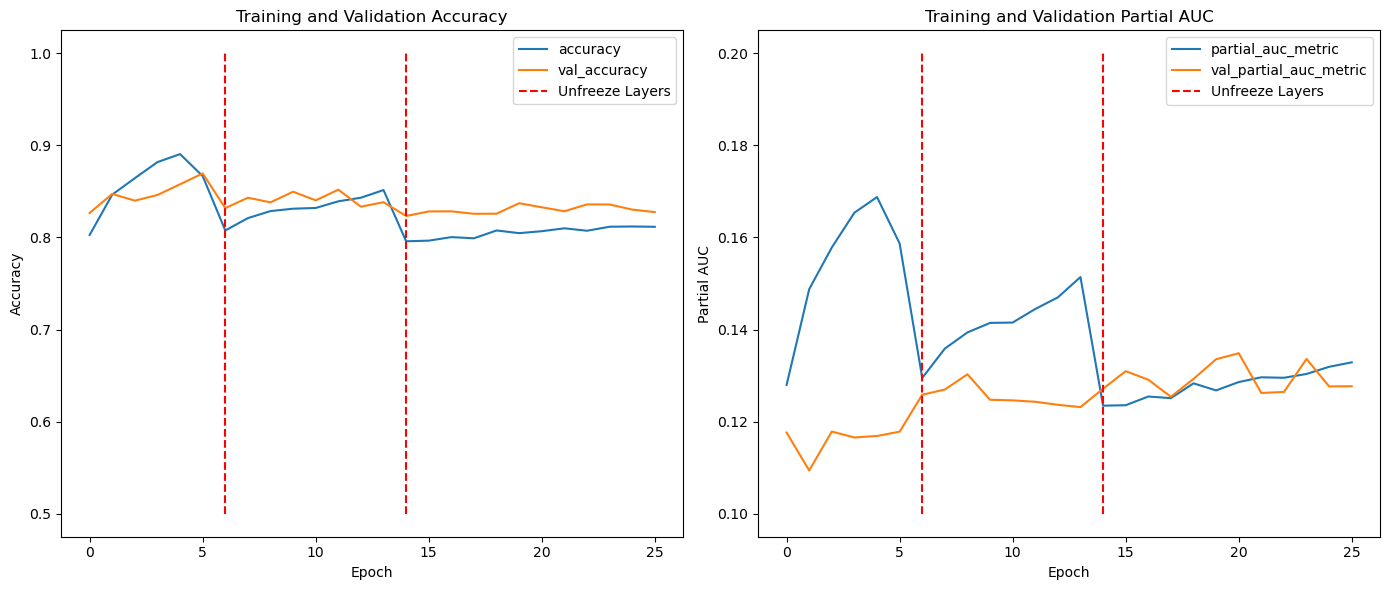

In [103]:
# Plot the training history
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(fold1_histories['accuracy'], label='accuracy')
plt.plot(fold1_histories['val_accuracy'], label='val_accuracy')
plt.vlines([6, 14], 0.5, 1, colors='r', linestyles='dashed', label='Unfreeze Layers')

plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(fold1_histories['partial_auc_metric'], label='partial_auc_metric')
plt.plot(fold1_histories['val_partial_auc_metric'], label='val_partial_auc_metric')
plt.vlines([6, 14], 0.1, 0.2, colors='r', linestyles='dashed', label='Unfreeze Layers')
plt.title('Training and Validation Partial AUC')
plt.xlabel('Epoch')
plt.ylabel('Partial AUC')
plt.legend()

plt.tight_layout()
plt.savefig('Fold1/training_history.png')

# Phase 2 (KFold 1)

In [19]:
# Perform K-Fold, Setting f=0
f = 1
training_df2, validation_df2 = stratified_group_k_fold(train_metadata_sample, N_FOLDS, RANDOM_SEED, f)

# Class Distribution in Training and Validation Data
print('Class Distribution in Training Data:')
display(training_df2['target'].value_counts())

print('Class Distribution in Validation Data:')
display(validation_df2['target'].value_counts())

Class Distribution in Training Data:


target
0    33159
1     3360
Name: count, dtype: int64

Class Distribution in Validation Data:


target
0    6908
1     570
Name: count, dtype: int64

In [20]:
# Define the data loaders
train_loader = TrainDataLoader(train_val_img, training_df2, training_df2[training_df2['target'] == 0].index, 
                                training_df2[training_df2['target'] == 1].index, batch_size=32, augment=True)

val_loader = ValidationDataLoader(train_val_img, validation_df2, batch_size=32, min_positive_samples=5)

# Define training and validation datasets
train_dataset = tf.data.Dataset.from_generator(
    lambda: train_loader,
    output_signature=(
        tf.TensorSpec(shape=(32, 128, 128, 3), dtype=tf.float32),  # Adjust shape based on batch size and image size
        tf.TensorSpec(shape=(32,), dtype=tf.int32)
    )
)

# Repeat for validation loader
val_dataset = tf.data.Dataset.from_generator(
    lambda: val_loader,
    output_signature=(
        tf.TensorSpec(shape=(32, 128, 128, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(32,), dtype=tf.int32)
    )
)

In [21]:
tf.keras.backend.clear_session()

# Build the model
model2 = build_model()

# Define Learning Rate Scheduler
initial_learning_rate = 1e-3
steps_per_epoch = len(train_loader)  # Total number of batches in the training set

lr_schedule = get_lr_scheduler(initial_learning_rate, steps_per_epoch, epochs_per_restart=5)
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=lr_schedule)

# Define Callbacks
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Define the checkpoint callback
checkpoint_callback = ModelCheckpoint(
    filepath='Fold2/model_{epoch:02d}.h5',  # Save a new file for each epoch
    save_weights_only=False,      # Save the entire model
    save_best_only=True,        # Save only the best model
    monitor='val_partial_auc_metric',  # Use the custom validation AUC metric
    mode='max',                 # Maximizing the AUC
    verbose=0
)

# Define the early stopping callback based on validation partial AUC
early_stopping_callback = EarlyStopping(
    monitor='val_partial_auc_metric',  # Monitor the custom validation AUC metric
    patience=5,                        # Number of epochs with no improvement before stopping
    mode='max',                        # Maximize the AUC
    min_delta=0.001,                   # Minimum change in the monitored quantity
    restore_best_weights=True,         # Restore the best weights after stopping
    verbose=1
)

# Compile the model
model2.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=['accuracy', partial_auc_metric]
)

# Define callbacks
callbacks = [checkpoint_callback, early_stopping_callback]

In [107]:
# Train the model
history1 = model2.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=30,
    steps_per_epoch=len(train_loader),
    validation_steps=len(val_loader),
    callbacks=callbacks
    )

Epoch 1/30


2024-11-11 17:25:36.982704: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


2072/2072 [==============================] - ETA: 0s - loss: 0.4242 - accuracy: 0.8088 - partial_auc_metric: 0.1301

2024-11-11 17:29:51.973734: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


2072/2072 [==============================] - 276s 132ms/step - loss: 0.4242 - accuracy: 0.8088 - partial_auc_metric: 0.1301 - val_loss: 0.3993 - val_accuracy: 0.8205 - val_partial_auc_metric: 0.1198
Epoch 2/30
2072/2072 [==============================] - 293s 141ms/step - loss: 0.3463 - accuracy: 0.8481 - partial_auc_metric: 0.1498 - val_loss: 0.3961 - val_accuracy: 0.8388 - val_partial_auc_metric: 0.0985
Epoch 3/30
2072/2072 [==============================] - 290s 140ms/step - loss: 0.3120 - accuracy: 0.8650 - partial_auc_metric: 0.1576 - val_loss: 0.3788 - val_accuracy: 0.8451 - val_partial_auc_metric: 0.1055
Epoch 4/30
2072/2072 [==============================] - 292s 141ms/step - loss: 0.2774 - accuracy: 0.8823 - partial_auc_metric: 0.1653 - val_loss: 0.4273 - val_accuracy: 0.8332 - val_partial_auc_metric: 0.0990
Epoch 5/30
2072/2072 [==============================] - 288s 139ms/step - loss: 0.2632 - accuracy: 0.8893 - partial_auc_metric: 0.1688 - val_loss: 0.4115 - val_accuracy: 0

In [108]:
# Save the training history
for key in fold2_histories.keys():
    fold2_histories[key].extend(history1.history[key])

In [110]:
# Unfreeze the last 30 layers of the EfficientNet base model
for layer in model2.layers[0].layers[-30:]:
    layer.trainable = True
    if hasattr(layer, 'kernel_regularizer'):
        layer.kernel_regularizer = l2(1e-4)

# Updated Learning Rate Scheduler for Fine-Tuning
initial_learning_rate = 5e-5  # Lower than the initial phase
epochs_per_restart = 5  # Shorter restart cycle

lr_schedule = get_lr_scheduler(initial_learning_rate, steps_per_epoch, epochs_per_restart)
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=lr_schedule)

# Define the checkpoint callback
checkpoint_callback = ModelCheckpoint(
    filepath='Fold2/model_{epoch:02d}.h5',  # Save a new file for each epoch
    save_weights_only=False,      # Save the entire model
    save_best_only=True,        # Save only the best model
    monitor='val_partial_auc_metric',  # Use the custom validation AUC metric
    mode='max',                 # Maximizing the AUC
    verbose=0
)

# Define the early stopping callback based on validation partial AUC
early_stopping_callback = EarlyStopping(
    monitor='val_partial_auc_metric',  # Monitor the custom validation AUC metric
    patience=5,                        # Number of epochs with no improvement before stopping
    mode='max',                        # Maximize the AUC
    min_delta=0.005,                   # Minimum change in the monitored quantity
    restore_best_weights=True,         # Restore the best weights after stopping
    verbose=1
)

# Define callbacks
callbacks = [checkpoint_callback, early_stopping_callback]

# Compile the model again with a lower learning rate for fine-tuning
model2.compile(optimizer=optimizer, 
              loss='binary_crossentropy',
              metrics=['accuracy', partial_auc_metric])

In [112]:
# Train the model
history2 = model2.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=30,
    initial_epoch=1,  # Start from the early stopping epoch
    steps_per_epoch=len(train_loader),
    validation_steps=len(val_loader),
    callbacks=callbacks
    )

Epoch 2/30
2072/2072 [==============================] - 279s 134ms/step - loss: 0.4712 - accuracy: 0.7799 - partial_auc_metric: 0.1165 - val_loss: 0.3448 - val_accuracy: 0.8266 - val_partial_auc_metric: 0.1412
Epoch 3/30
2072/2072 [==============================] - 288s 139ms/step - loss: 0.4167 - accuracy: 0.8075 - partial_auc_metric: 0.1303 - val_loss: 0.3688 - val_accuracy: 0.8136 - val_partial_auc_metric: 0.1522
Epoch 4/30
2072/2072 [==============================] - 294s 142ms/step - loss: 0.3957 - accuracy: 0.8207 - partial_auc_metric: 0.1354 - val_loss: 0.3732 - val_accuracy: 0.8120 - val_partial_auc_metric: 0.1481
Epoch 5/30
2072/2072 [==============================] - 300s 145ms/step - loss: 0.3879 - accuracy: 0.8240 - partial_auc_metric: 0.1380 - val_loss: 0.3751 - val_accuracy: 0.8201 - val_partial_auc_metric: 0.1478
Epoch 6/30
2072/2072 [==============================] - 299s 144ms/step - loss: 0.3893 - accuracy: 0.8229 - partial_auc_metric: 0.1382 - val_loss: 0.3782 - val_

In [113]:
# Save the training history
for key in fold2_histories.keys():
    fold2_histories[key].extend(history2.history[key])

In [115]:
# Update learning rate and scheduler
initial_learning_rate = 1e-5  # Reduced learning rate
epochs_per_restart = 3        # Shorter restart cycle for fine-tuning
lr_schedule = get_lr_scheduler(initial_learning_rate, steps_per_epoch, epochs_per_restart)

# Update optimizer with new learning rate
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=lr_schedule)

# Unfreeze additional layers
for layer in model2.layers[0].layers[-50:]:  # Unfreeze 50 more layers as an example
    layer.trainable = True
    if hasattr(layer, 'kernel_regularizer'):
        layer.kernel_regularizer = l2(1e-4)

# Compile and fit the model for Phase 3
model2.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy', partial_auc_metric])

In [116]:
# Train the model
history3 = model2.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=30,
    initial_epoch=3,  # Start from the early stopping epoch
    steps_per_epoch=len(train_loader),
    validation_steps=len(val_loader),
    callbacks=callbacks
    )

Epoch 4/30
2072/2072 [==============================] - 293s 140ms/step - loss: 0.4800 - accuracy: 0.7708 - partial_auc_metric: 0.1125 - val_loss: 0.3886 - val_accuracy: 0.8189 - val_partial_auc_metric: 0.1313
Epoch 5/30
2072/2072 [==============================] - 308s 149ms/step - loss: 0.4605 - accuracy: 0.7805 - partial_auc_metric: 0.1175 - val_loss: 0.4272 - val_accuracy: 0.7885 - val_partial_auc_metric: 0.1329
Epoch 6/30
2072/2072 [==============================] - 316s 153ms/step - loss: 0.4604 - accuracy: 0.7836 - partial_auc_metric: 0.1172 - val_loss: 0.4161 - val_accuracy: 0.8066 - val_partial_auc_metric: 0.1365
Epoch 7/30
2072/2072 [==============================] - 317s 153ms/step - loss: 0.4483 - accuracy: 0.7906 - partial_auc_metric: 0.1215 - val_loss: 0.4302 - val_accuracy: 0.7910 - val_partial_auc_metric: 0.1351
Epoch 8/30
2072/2072 [==============================] - 351s 170ms/step - loss: 0.4481 - accuracy: 0.7897 - partial_auc_metric: 0.1210 - val_loss: 0.4163 - val_

In [117]:
# Save the training history
for key in fold2_histories.keys():
    fold2_histories[key].extend(history3.history[key])

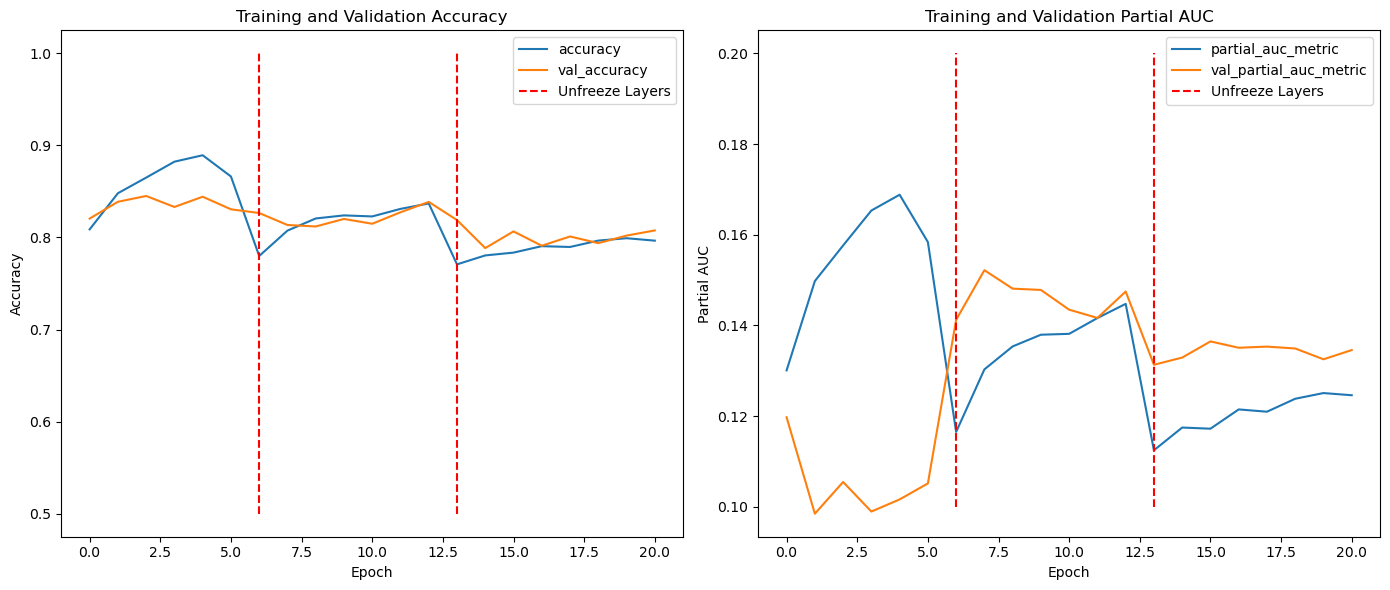

In [126]:
# Plot the training history
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(fold2_histories['accuracy'], label='accuracy')
plt.plot(fold2_histories['val_accuracy'], label='val_accuracy')
plt.vlines([6, 13], 0.5, 1, colors='r', linestyles='dashed', label='Unfreeze Layers')

plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(fold2_histories['partial_auc_metric'], label='partial_auc_metric')
plt.plot(fold2_histories['val_partial_auc_metric'], label='val_partial_auc_metric')
plt.vlines([6, 13], 0.1, 0.2, colors='r', linestyles='dashed', label='Unfreeze Layers')
plt.title('Training and Validation Partial AUC')
plt.xlabel('Epoch')
plt.ylabel('Partial AUC')
plt.legend()

plt.tight_layout()
plt.savefig('Fold2/training_history.png')

In [22]:
# Load the best model
model2 = tf.keras.models.load_model('Fold2/model_03.h5', custom_objects={'partial_auc_metric': partial_auc_metric})

# Make predictions on the validation set
test_loader = TestDataLoader(train_val_img, validation_df2, batch_size=32)

test_dataset = tf.data.Dataset.from_generator(
    lambda: test_loader,
    output_signature=(
        tf.TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32)
    )
)

# Estimate the number of batches in the test dataset
num_batches = len(test_loader)

# Wrap the predictions call with tqdm
predictions = []
for batch in tqdm(test_dataset, total=num_batches, desc="Predicting"):
    batch_preds = model2.predict(batch, verbose=0)
    predictions.append(batch_preds)

# Convert predictions to a single numpy array
predictions = np.concatenate(predictions, axis=0)

# Calculate the partial AUC
partial_auc = partial_auc_metric(validation_df2['target'].values, predictions)
print(f"Partial AUC: {partial_auc:.4f}")

Predicting:   0%|          | 0/234 [00:00<?, ?it/s]

2024-11-22 22:20:13.698018: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


Partial AUC: 0.1431


In [23]:
# Add predictions to the validation DataFrame
validation_df2['cnn_confidence'] = predictions

# Phase 3 (OOF for f=2)

In [24]:
# Perform K-Fold, Setting f=2
f = 2
training_df3, validation_df3 = stratified_group_k_fold(train_metadata_sample, N_FOLDS, RANDOM_SEED, f)

# Class Distribution in Training and Validation Data
print('Class Distribution in Training Data:')
display(training_df2['target'].value_counts())

print('Class Distribution in Validation Data:')
display(validation_df2['target'].value_counts())

Class Distribution in Training Data:


target
0    33159
1     3360
Name: count, dtype: int64

Class Distribution in Validation Data:


target
0    6908
1     570
Name: count, dtype: int64

In [25]:
# Define the data loaders
train_loader = TrainDataLoader(train_val_img, training_df3, training_df3[training_df3['target'] == 0].index, 
                                training_df3[training_df3['target'] == 1].index, batch_size=32, augment=True)

val_loader = ValidationDataLoader(train_val_img, validation_df3, batch_size=32, min_positive_samples=5)

# Define training and validation datasets
train_dataset = tf.data.Dataset.from_generator(
    lambda: train_loader,
    output_signature=(
        tf.TensorSpec(shape=(32, 128, 128, 3), dtype=tf.float32),  # Adjust shape based on batch size and image size
        tf.TensorSpec(shape=(32,), dtype=tf.int32)
    )
)

val_dataset = tf.data.Dataset.from_generator(
    lambda: val_loader,
    output_signature=(
        tf.TensorSpec(shape=(32, 128, 128, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(32,), dtype=tf.int32)
    )
)

In [26]:
tf.keras.backend.clear_session()

# Build the model
model3 = build_model()

# Define Learning Rate Scheduler
initial_learning_rate = 1e-3
steps_per_epoch = len(train_loader)  # Total number of batches in the training set

lr_schedule = get_lr_scheduler(initial_learning_rate, steps_per_epoch, epochs_per_restart=5)
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=lr_schedule)

# Define Callbacks
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Define the checkpoint callback
checkpoint_callback = ModelCheckpoint(
    filepath='Fold3/model_{epoch:02d}.h5',  # Save a new file for each epoch
    save_weights_only=False,      # Save the entire model
    save_best_only=True,        # Save only the best model
    monitor='val_partial_auc_metric',  # Use the custom validation AUC metric
    mode='max',                 # Maximizing the AUC
    verbose=0
)

# Define the early stopping callback based on validation partial AUC
early_stopping_callback = EarlyStopping(
    monitor='val_partial_auc_metric',  # Monitor the custom validation AUC metric
    patience=4,                        # Number of epochs with no improvement before stopping
    mode='max',                        # Maximize the AUC
    min_delta=0.001,                   # Minimum change in the monitored quantity
    restore_best_weights=True,         # Restore the best weights after stopping
    verbose=1
)

# Compile the model
model3.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=['accuracy', partial_auc_metric]
)

# Define callbacks
callbacks = [checkpoint_callback, early_stopping_callback]

In [128]:
# Train the model
history1 = model3.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=30,
    steps_per_epoch=len(train_loader),
    validation_steps=len(val_loader),
    callbacks=callbacks
    )

Epoch 1/30


2024-11-11 19:25:40.590515: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


1958/1958 [==============================] - ETA: 0s - loss: 0.4248 - accuracy: 0.8072 - partial_auc_metric: 0.1309

2024-11-11 19:29:51.057867: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


1958/1958 [==============================] - 276s 140ms/step - loss: 0.4248 - accuracy: 0.8072 - partial_auc_metric: 0.1309 - val_loss: 0.3510 - val_accuracy: 0.8662 - val_partial_auc_metric: 0.1088
Epoch 2/30
1958/1958 [==============================] - 287s 146ms/step - loss: 0.3380 - accuracy: 0.8505 - partial_auc_metric: 0.1514 - val_loss: 0.3340 - val_accuracy: 0.8780 - val_partial_auc_metric: 0.1143
Epoch 3/30
1958/1958 [==============================] - 293s 150ms/step - loss: 0.3063 - accuracy: 0.8697 - partial_auc_metric: 0.1595 - val_loss: 0.3731 - val_accuracy: 0.8695 - val_partial_auc_metric: 0.1044
Epoch 4/30
1958/1958 [==============================] - 295s 151ms/step - loss: 0.2691 - accuracy: 0.8876 - partial_auc_metric: 0.1679 - val_loss: 0.3885 - val_accuracy: 0.8700 - val_partial_auc_metric: 0.1010
Epoch 5/30
1958/1958 [==============================] - 297s 152ms/step - loss: 0.2589 - accuracy: 0.8915 - partial_auc_metric: 0.1696 - val_loss: 0.3932 - val_accuracy: 0

In [129]:
# Save the training history
for key in fold3_histories.keys():
    fold3_histories[key].extend(history1.history[key])

In [133]:
# Unfreeze the last 30 layers of the EfficientNet base model
for layer in model3.layers[0].layers[-30:]:
    layer.trainable = True
    if hasattr(layer, 'kernel_regularizer'):
        layer.kernel_regularizer = l2(1e-4)

# Updated Learning Rate Scheduler for Fine-Tuning
initial_learning_rate = 5e-5  # Lower than the initial phase
epochs_per_restart = 5  # Shorter restart cycle

lr_schedule = get_lr_scheduler(initial_learning_rate, steps_per_epoch, epochs_per_restart)
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=lr_schedule)

# Compile the model again with a lower learning rate for fine-tuning
model3.compile(optimizer=optimizer, 
              loss='binary_crossentropy',
              metrics=['accuracy', partial_auc_metric])

In [135]:
# Train the model
history2 = model3.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=30,
    initial_epoch=2,  # Start from the early stopping epoch
    steps_per_epoch=len(train_loader),
    validation_steps=len(val_loader),
    callbacks=callbacks
    )

Epoch 3/30
1958/1958 [==============================] - 286s 145ms/step - loss: 0.4754 - accuracy: 0.7794 - partial_auc_metric: 0.1166 - val_loss: 0.4166 - val_accuracy: 0.8257 - val_partial_auc_metric: 0.1019
Epoch 4/30
1958/1958 [==============================] - 271s 139ms/step - loss: 0.4087 - accuracy: 0.8131 - partial_auc_metric: 0.1319 - val_loss: 0.4029 - val_accuracy: 0.8292 - val_partial_auc_metric: 0.1082
Epoch 5/30
1958/1958 [==============================] - 274s 140ms/step - loss: 0.3969 - accuracy: 0.8194 - partial_auc_metric: 0.1360 - val_loss: 0.4094 - val_accuracy: 0.8298 - val_partial_auc_metric: 0.1052
Epoch 6/30
1958/1958 [==============================] - 269s 137ms/step - loss: 0.3849 - accuracy: 0.8252 - partial_auc_metric: 0.1389 - val_loss: 0.3741 - val_accuracy: 0.8416 - val_partial_auc_metric: 0.1161
Epoch 7/30
1958/1958 [==============================] - 271s 139ms/step - loss: 0.3809 - accuracy: 0.8299 - partial_auc_metric: 0.1403 - val_loss: 0.3924 - val_

In [136]:
# Save the training history
for key in fold3_histories.keys():
    fold3_histories[key].extend(history2.history[key])

In [141]:
# Update learning rate and scheduler
initial_learning_rate = 1e-5  # Reduced learning rate
epochs_per_restart = 3        # Shorter restart cycle for fine-tuning
lr_schedule = get_lr_scheduler(initial_learning_rate, steps_per_epoch, epochs_per_restart)

# Update optimizer with new learning rate
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=lr_schedule)

# Unfreeze additional layers
for layer in model3.layers[0].layers[-50:]:  # Unfreeze 50 more layers as an example
    layer.trainable = True
    if hasattr(layer, 'kernel_regularizer'):
        layer.kernel_regularizer = l2(2e-4)

# Compile and fit the model for Phase 3
model3.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy', partial_auc_metric])

In [142]:
# Train the model
history3 = model3.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=30,
    initial_epoch=6,  # Start from the early stopping epoch
    steps_per_epoch=len(train_loader),
    validation_steps=len(val_loader),
    callbacks=callbacks
    )

Epoch 7/30
1958/1958 [==============================] - 278s 141ms/step - loss: 0.4401 - accuracy: 0.7951 - partial_auc_metric: 0.1240 - val_loss: 0.4385 - val_accuracy: 0.8019 - val_partial_auc_metric: 0.1053
Epoch 8/30
1958/1958 [==============================] - 276s 141ms/step - loss: 0.4317 - accuracy: 0.7988 - partial_auc_metric: 0.1260 - val_loss: 0.4456 - val_accuracy: 0.8044 - val_partial_auc_metric: 0.0980
Epoch 9/30
1958/1958 [==============================] - 278s 142ms/step - loss: 0.4346 - accuracy: 0.7994 - partial_auc_metric: 0.1248 - val_loss: 0.4429 - val_accuracy: 0.8023 - val_partial_auc_metric: 0.1097
Epoch 10/30
1958/1958 [==============================] - 277s 142ms/step - loss: 0.4303 - accuracy: 0.8012 - partial_auc_metric: 0.1262 - val_loss: 0.4424 - val_accuracy: 0.8032 - val_partial_auc_metric: 0.0990
Epoch 11/30
1958/1958 [==============================] - 278s 142ms/step - loss: 0.4210 - accuracy: 0.8072 - partial_auc_metric: 0.1291 - val_loss: 0.4269 - va

In [143]:
# Save the training history
for key in fold3_histories.keys():
    fold3_histories[key].extend(history3.history[key])

In [144]:
len(history1.history['accuracy']), len(history2.history['accuracy']), len(history3.history['accuracy'])

(6, 8, 10)

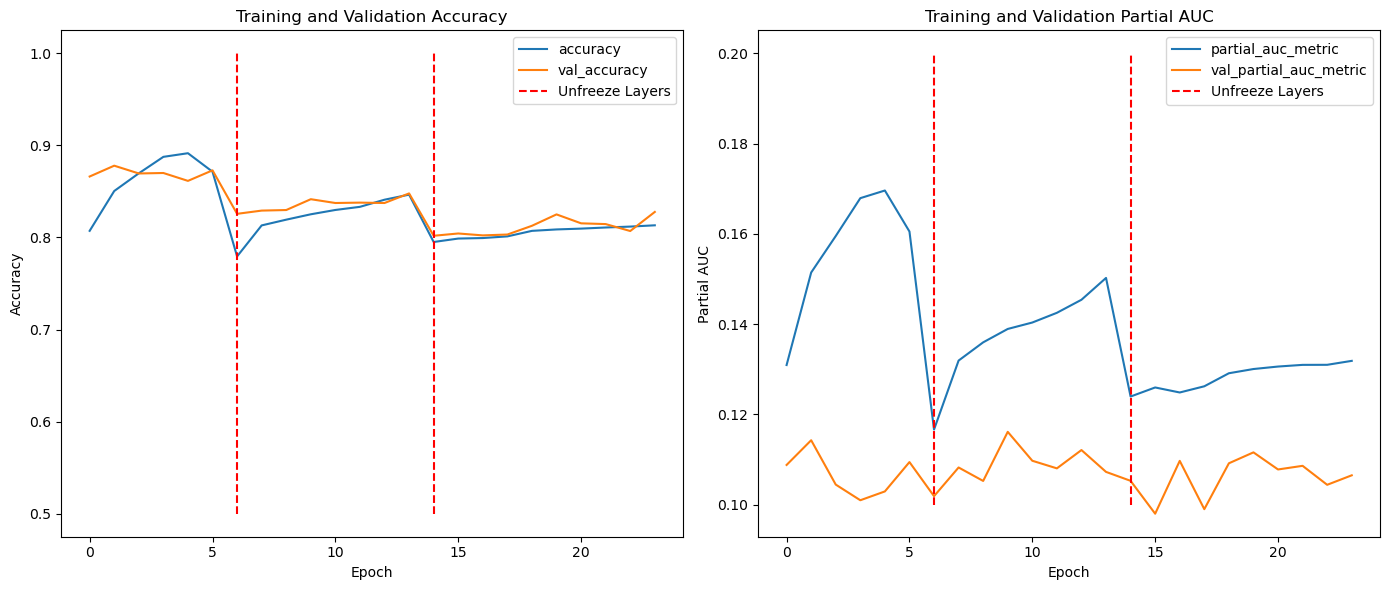

In [145]:
# Plot the training history
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(fold3_histories['accuracy'], label='accuracy')
plt.plot(fold3_histories['val_accuracy'], label='val_accuracy')
plt.vlines([6, 14], 0.5, 1, colors='r', linestyles='dashed', label='Unfreeze Layers')

plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(fold3_histories['partial_auc_metric'], label='partial_auc_metric')
plt.plot(fold3_histories['val_partial_auc_metric'], label='val_partial_auc_metric')
plt.vlines([6, 14], 0.1, 0.2, colors='r', linestyles='dashed', label='Unfreeze Layers')
plt.title('Training and Validation Partial AUC')
plt.xlabel('Epoch')
plt.ylabel('Partial AUC')
plt.legend()

plt.tight_layout()
#plt.savefig('Fold3/training_history.png')

In [27]:
# Load the best model
model3 = tf.keras.models.load_model('Fold3/model_06.h5', custom_objects={'partial_auc_metric': partial_auc_metric})

In [28]:
# Make predictions on the validation set
test_loader = TestDataLoader(train_val_img, validation_df3, batch_size=32)

test_dataset = tf.data.Dataset.from_generator(
    lambda: test_loader,
    output_signature=(
        tf.TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32)
    )
)

# Estimate the number of batches in the test dataset
num_batches = len(test_loader)

# Wrap the predictions call with tqdm
predictions = []
for batch in tqdm(test_dataset, total=num_batches, desc="Predicting"):
    batch_preds = model3.predict(batch, verbose=0)
    predictions.append(batch_preds)

# Convert predictions to a single numpy array
predictions = np.concatenate(predictions, axis=0)

# Calculate the partial AUC
partial_auc = partial_auc_metric(validation_df3['target'].values, predictions)
print(f"Partial AUC: {partial_auc:.4f}")

Predicting:   0%|          | 0/304 [00:00<?, ?it/s]

2024-11-22 22:21:05.885083: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


Partial AUC: 0.0901


In [29]:
# Add predictions to the validation DataFrame
validation_df3['cnn_confidence'] = predictions

# Phase 4 (OOF f=3)

In [30]:
# Perform K-Fold, Setting f=3
f = 3
training_df4, validation_df4 = stratified_group_k_fold(train_metadata_sample, N_FOLDS, RANDOM_SEED, f)

# Class Distribution in Training and Validation Data
print('Class Distribution in Training Data:')
display(training_df4['target'].value_counts())

print('Class Distribution in Validation Data:')
display(validation_df4['target'].value_counts())

Class Distribution in Training Data:


target
0    32696
1     3189
Name: count, dtype: int64

Class Distribution in Validation Data:


target
0    7371
1     741
Name: count, dtype: int64

In [31]:
# Define the data loaders
train_loader = TrainDataLoader(train_val_img, training_df4, training_df4[training_df4['target'] == 0].index, 
                                training_df4[training_df4['target'] == 1].index, batch_size=32, augment=True)

val_loader = ValidationDataLoader(train_val_img, validation_df4, batch_size=32, min_positive_samples=5)

# Define training and validation datasets
train_dataset = tf.data.Dataset.from_generator(
    lambda: train_loader,
    output_signature=(
        tf.TensorSpec(shape=(32, 128, 128, 3), dtype=tf.float32),  # Adjust shape based on batch size and image size
        tf.TensorSpec(shape=(32,), dtype=tf.int32)
    )
)

val_dataset = tf.data.Dataset.from_generator(
    lambda: val_loader,
    output_signature=(
        tf.TensorSpec(shape=(32, 128, 128, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(32,), dtype=tf.int32)
    )
)

In [32]:
# Build the model
model4 = build_model()

# Define Learning Rate Scheduler
initial_learning_rate = 1e-3
steps_per_epoch = len(train_loader)  # Total number of batches in the training set

lr_schedule = get_lr_scheduler(initial_learning_rate, steps_per_epoch, epochs_per_restart=5)
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=lr_schedule)

# Define the checkpoint callback
checkpoint_callback = ModelCheckpoint(
    filepath='Fold4/model_{epoch:02d}.h5',  # Save a new file for each epoch
    save_weights_only=False,      # Save the entire model
    save_best_only=True,        # Save only the best model
    monitor='val_partial_auc_metric',  # Use the custom validation AUC metric
    mode='max',                 # Maximizing the AUC
    verbose=0
)

# Define the early stopping callback based on validation partial AUC
early_stopping_callback = EarlyStopping(
    monitor='val_partial_auc_metric',  # Monitor the custom validation AUC metric
    patience=4,                        # Number of epochs with no improvement before stopping
    mode='max',                        # Maximize the AUC
    min_delta=0.001,                   # Minimum change in the monitored quantity
    restore_best_weights=True,         # Restore the best weights after stopping
    verbose=1
)

# Compile the model
model4.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=['accuracy', partial_auc_metric]
)

# Define callbacks
callbacks = [checkpoint_callback, early_stopping_callback]

In [152]:
# Train the model
history1 = model4.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=30,
    steps_per_epoch=len(train_loader),
    validation_steps=len(val_loader),
    callbacks=callbacks
    )

Epoch 1/30


2024-11-11 22:28:39.031428: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


2043/2043 [==============================] - ETA: 0s - loss: 0.4254 - accuracy: 0.8101 - partial_auc_metric: 0.1308

2024-11-11 22:32:53.942139: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


2043/2043 [==============================] - 278s 135ms/step - loss: 0.4254 - accuracy: 0.8101 - partial_auc_metric: 0.1308 - val_loss: 0.4502 - val_accuracy: 0.7850 - val_partial_auc_metric: 0.1131
Epoch 2/30
2043/2043 [==============================] - 299s 146ms/step - loss: 0.3443 - accuracy: 0.8481 - partial_auc_metric: 0.1506 - val_loss: 0.3819 - val_accuracy: 0.8551 - val_partial_auc_metric: 0.1059
Epoch 3/30
2043/2043 [==============================] - 285s 140ms/step - loss: 0.3083 - accuracy: 0.8669 - partial_auc_metric: 0.1592 - val_loss: 0.3616 - val_accuracy: 0.8602 - val_partial_auc_metric: 0.1208
Epoch 4/30
2043/2043 [==============================] - 290s 142ms/step - loss: 0.2735 - accuracy: 0.8844 - partial_auc_metric: 0.1674 - val_loss: 0.3644 - val_accuracy: 0.8554 - val_partial_auc_metric: 0.1209
Epoch 5/30
2043/2043 [==============================] - 341s 167ms/step - loss: 0.2593 - accuracy: 0.8918 - partial_auc_metric: 0.1697 - val_loss: 0.3826 - val_accuracy: 0

In [153]:
# Save the training history
for key in fold4_histories.keys():
    fold4_histories[key].extend(history1.history[key])

In [154]:
# Unfreeze the last 30 layers of the EfficientNet base model
for layer in model4.layers[0].layers[-30:]:
    layer.trainable = True
    if hasattr(layer, 'kernel_regularizer'):
        layer.kernel_regularizer = l2(1e-5)

# Updated Learning Rate Scheduler for Fine-Tuning
initial_learning_rate = 5e-5  # Lower than the initial phase
epochs_per_restart = 5  # Shorter restart cycle

lr_schedule = get_lr_scheduler(initial_learning_rate, steps_per_epoch, epochs_per_restart)
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=lr_schedule)

# Compile the model again with a lower learning rate for fine-tuning
model4.compile(optimizer=optimizer, 
              loss='binary_crossentropy',
              metrics=['accuracy', partial_auc_metric])

In [155]:
# Train the model
history2 = model4.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=30,
    initial_epoch=3,  # Start from the early stopping epoch
    steps_per_epoch=len(train_loader),
    validation_steps=len(val_loader),
    callbacks=callbacks
    )

Epoch 4/30
2043/2043 [==============================] - 286s 139ms/step - loss: 0.4856 - accuracy: 0.7779 - partial_auc_metric: 0.1152 - val_loss: 0.4034 - val_accuracy: 0.8284 - val_partial_auc_metric: 0.1102
Epoch 5/30
2043/2043 [==============================] - 294s 144ms/step - loss: 0.4162 - accuracy: 0.8101 - partial_auc_metric: 0.1309 - val_loss: 0.3995 - val_accuracy: 0.8247 - val_partial_auc_metric: 0.1130
Epoch 6/30
2043/2043 [==============================] - 306s 150ms/step - loss: 0.3891 - accuracy: 0.8251 - partial_auc_metric: 0.1386 - val_loss: 0.3903 - val_accuracy: 0.8298 - val_partial_auc_metric: 0.1177
Epoch 7/30
2043/2043 [==============================] - 298s 146ms/step - loss: 0.3868 - accuracy: 0.8256 - partial_auc_metric: 0.1387 - val_loss: 0.3985 - val_accuracy: 0.8298 - val_partial_auc_metric: 0.1181
Epoch 8/30
2043/2043 [==============================] - 295s 144ms/step - loss: 0.3844 - accuracy: 0.8270 - partial_auc_metric: 0.1398 - val_loss: 0.3943 - val_

In [156]:
# Save the training history
for key in fold4_histories.keys():
    fold4_histories[key].extend(history2.history[key])

In [157]:
# Update learning rate and scheduler
initial_learning_rate = 1e-5  # Reduced learning rate
epochs_per_restart = 3        # Shorter restart cycle for fine-tuning
lr_schedule = get_lr_scheduler(initial_learning_rate, steps_per_epoch, epochs_per_restart)

# Update optimizer with new learning rate
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=lr_schedule)

# Unfreeze additional layers
for layer in model4.layers[0].layers[-50:-30]:  # Unfreeze 50 more layers as an example
    layer.trainable = True
    if hasattr(layer, 'kernel_regularizer'):
        layer.kernel_regularizer = l2(1e-4)

# Compile and fit the model for Phase 3
model4.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy', partial_auc_metric])

In [158]:
# Train the model
history3 = model4.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=30,
    initial_epoch=9,  # Start from the early stopping epoch
    steps_per_epoch=len(train_loader),
    validation_steps=len(val_loader),
    callbacks=callbacks
    )

Epoch 10/30
2043/2043 [==============================] - 289s 140ms/step - loss: 0.4635 - accuracy: 0.7847 - partial_auc_metric: 0.1186 - val_loss: 0.4460 - val_accuracy: 0.8193 - val_partial_auc_metric: 0.0904
Epoch 11/30
2043/2043 [==============================] - 321s 157ms/step - loss: 0.4482 - accuracy: 0.7917 - partial_auc_metric: 0.1228 - val_loss: 0.4762 - val_accuracy: 0.7922 - val_partial_auc_metric: 0.0823
Epoch 12/30
2043/2043 [==============================] - 312s 153ms/step - loss: 0.4384 - accuracy: 0.7961 - partial_auc_metric: 0.1247 - val_loss: 0.4731 - val_accuracy: 0.7946 - val_partial_auc_metric: 0.0865
Epoch 13/30
2043/2043 [==============================] - 294s 144ms/step - loss: 0.4320 - accuracy: 0.8008 - partial_auc_metric: 0.1268 - val_loss: 0.4493 - val_accuracy: 0.8021 - val_partial_auc_metric: 0.0891
Epoch 14/30
2043/2043 [==============================] - 304s 149ms/step - loss: 0.4259 - accuracy: 0.8047 - partial_auc_metric: 0.1282 - val_loss: 0.4616 -

In [159]:
# Save the training history
for key in fold4_histories.keys():
    fold4_histories[key].extend(history3.history[key])

In [161]:
len(history1.history['accuracy']), len(history2.history['accuracy']), len(history3.history['accuracy'])

(7, 10, 5)

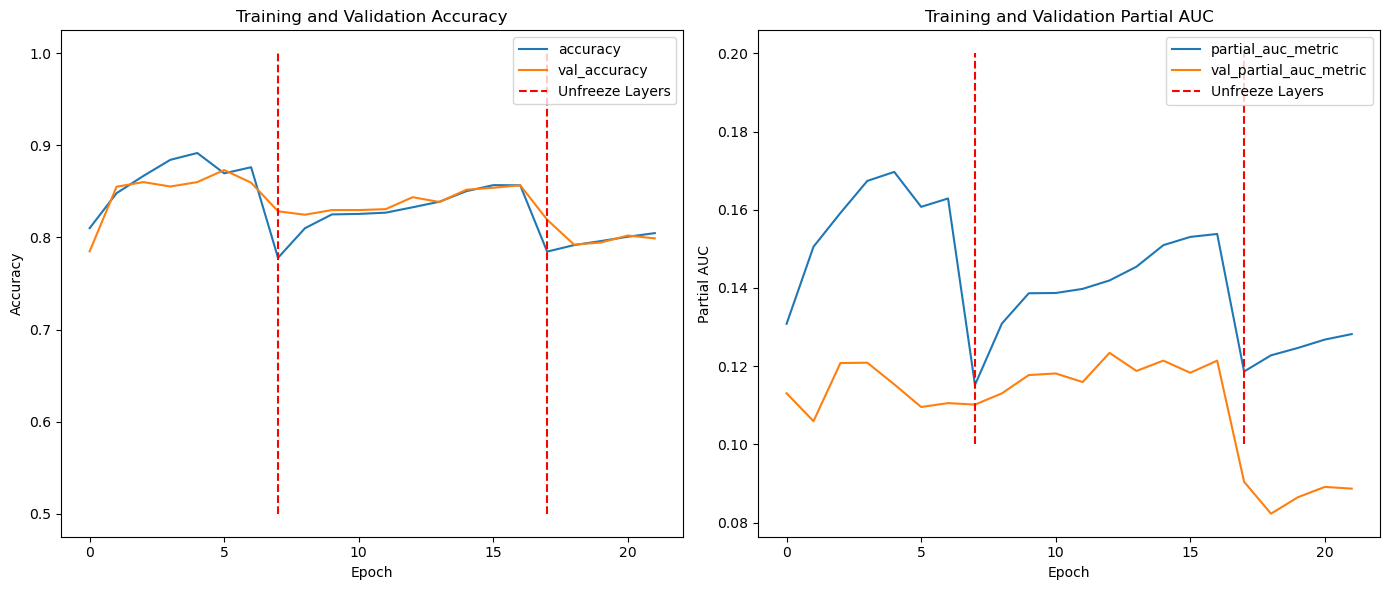

In [163]:
# Plot the training history
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(fold4_histories['accuracy'], label='accuracy')
plt.plot(fold4_histories['val_accuracy'], label='val_accuracy')
plt.vlines([7, 17], 0.5, 1, colors='r', linestyles='dashed', label='Unfreeze Layers')

plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(fold4_histories['partial_auc_metric'], label='partial_auc_metric')
plt.plot(fold4_histories['val_partial_auc_metric'], label='val_partial_auc_metric')
plt.vlines([7, 17], 0.1, 0.2, colors='r', linestyles='dashed', label='Unfreeze Layers')
plt.title('Training and Validation Partial AUC')
plt.xlabel('Epoch')
plt.ylabel('Partial AUC')
plt.legend()

plt.tight_layout()
plt.savefig('Fold4/training_history.png')

In [33]:
# Load the best model
model4 = tf.keras.models.load_model('Fold4/model_09.h5', custom_objects={'partial_auc_metric': partial_auc_metric})

In [34]:
# Make predictions on the validation set
test_loader = TestDataLoader(train_val_img, validation_df4, batch_size=32)

test_dataset = tf.data.Dataset.from_generator(
    lambda: test_loader,
    output_signature=(
        tf.TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32)
    )
)

# Estimate the number of batches in the test dataset
num_batches = len(test_loader)

# Wrap the predictions call with tqdm
predictions = []
for batch in tqdm(test_dataset, total=num_batches, desc="Predicting"):
    batch_preds = model4.predict(batch, verbose=0)
    predictions.append(batch_preds)

# Convert predictions to a single numpy array
predictions = np.concatenate(predictions, axis=0)

# Calculate the partial AUC
partial_auc = partial_auc_metric(validation_df4['target'].values, predictions)
print(f"Partial AUC: {partial_auc:.4f}")

Predicting:   0%|          | 0/254 [00:00<?, ?it/s]

2024-11-22 22:21:51.890746: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


Partial AUC: 0.1025


In [35]:
# Add predictions to the validation DataFrame
validation_df4['cnn_confidence'] = predictions

# Phase 5 (OOF f=4)

In [36]:
# Perform K-Fold, Setting f=4
f = 4
training_df5, validation_df5 = stratified_group_k_fold(train_metadata_sample, N_FOLDS, RANDOM_SEED, f)

# Class Distribution in Training and Validation Data
print('Class Distribution in Training Data:')
display(training_df5['target'].value_counts())

print('Class Distribution in Validation Data:')
display(validation_df5['target'].value_counts())

Class Distribution in Training Data:


target
0    33038
1     3161
Name: count, dtype: int64

Class Distribution in Validation Data:


target
0    7029
1     769
Name: count, dtype: int64

In [37]:
# Define the data loaders
train_loader = TrainDataLoader(train_val_img, training_df5, training_df5[training_df5['target'] == 0].index, 
                                training_df5[training_df5['target'] == 1].index, batch_size=32, augment=True)

val_loader = ValidationDataLoader(train_val_img, validation_df5, batch_size=32, min_positive_samples=5)

# Define training and validation datasets
train_dataset = tf.data.Dataset.from_generator(
    lambda: train_loader,
    output_signature=(
        tf.TensorSpec(shape=(32, 128, 128, 3), dtype=tf.float32),  # Adjust shape based on batch size and image size
        tf.TensorSpec(shape=(32,), dtype=tf.int32)
    )
)

val_dataset = tf.data.Dataset.from_generator(
    lambda: val_loader,
    output_signature=(
        tf.TensorSpec(shape=(32, 128, 128, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(32,), dtype=tf.int32)
    )
)

In [38]:
# Build the model
model5 = build_model()

# Define Learning Rate Scheduler
initial_learning_rate = 1e-3
steps_per_epoch = len(train_loader)  # Total number of batches in the training set

lr_schedule = get_lr_scheduler(initial_learning_rate, steps_per_epoch, epochs_per_restart=5)
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=lr_schedule)

# Define the checkpoint callback
checkpoint_callback = ModelCheckpoint(
    filepath='Fold5/model_{epoch:02d}.h5',  # Save a new file for each epoch
    save_weights_only=False,      # Save the entire model
    save_best_only=True,        # Save only the best model
    monitor='val_partial_auc_metric',  # Use the custom validation AUC metric
    mode='max',                 # Maximizing the AUC
    verbose=0
)

# Define the early stopping callback based on validation partial AUC
early_stopping_callback = EarlyStopping(
    monitor='val_partial_auc_metric',  # Monitor the custom validation AUC metric
    patience=4,                        # Number of epochs with no improvement before stopping
    mode='max',                        # Maximize the AUC
    min_delta=0.001,                   # Minimum change in the monitored quantity
    restore_best_weights=True,         # Restore the best weights after stopping
    verbose=1
)

# Compile the model
model5.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=['accuracy', partial_auc_metric]
)

# Define callbacks
callbacks = [checkpoint_callback, early_stopping_callback] 

In [171]:
# Train the model
history1 = model5.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=30,
    steps_per_epoch=len(train_loader),
    validation_steps=len(val_loader),
    callbacks=callbacks
    )

Epoch 1/30


2024-11-12 00:28:08.336935: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


2064/2064 [==============================] - ETA: 0s - loss: 0.4247 - accuracy: 0.8071 - partial_auc_metric: 0.1309

2024-11-12 00:32:40.188540: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


2064/2064 [==============================] - 293s 140ms/step - loss: 0.4247 - accuracy: 0.8071 - partial_auc_metric: 0.1309 - val_loss: 0.3394 - val_accuracy: 0.8589 - val_partial_auc_metric: 0.1162
Epoch 2/30
2064/2064 [==============================] - 293s 142ms/step - loss: 0.3463 - accuracy: 0.8460 - partial_auc_metric: 0.1501 - val_loss: 0.4012 - val_accuracy: 0.8162 - val_partial_auc_metric: 0.1199
Epoch 3/30
2064/2064 [==============================] - 293s 142ms/step - loss: 0.3112 - accuracy: 0.8654 - partial_auc_metric: 0.1585 - val_loss: 0.3579 - val_accuracy: 0.8562 - val_partial_auc_metric: 0.1161
Epoch 4/30
2064/2064 [==============================] - 300s 145ms/step - loss: 0.2787 - accuracy: 0.8819 - partial_auc_metric: 0.1656 - val_loss: 0.3749 - val_accuracy: 0.8651 - val_partial_auc_metric: 0.1122
Epoch 5/30
2064/2064 [==============================] - 301s 146ms/step - loss: 0.2629 - accuracy: 0.8889 - partial_auc_metric: 0.1691 - val_loss: 0.3824 - val_accuracy: 0

In [172]:
# Save the training history
for key in fold5_histories.keys():
    fold5_histories[key].extend(history1.history[key])

In [173]:
# Unfreeze the last 30 layers of the EfficientNet base model
for layer in model5.layers[0].layers[-30:]:
    layer.trainable = True
    if hasattr(layer, 'kernel_regularizer'):
        layer.kernel_regularizer = l2(1e-5)

# Updated Learning Rate Scheduler for Fine-Tuning
initial_learning_rate = 5e-5  # Lower than the initial phase
epochs_per_restart = 5  # Shorter restart cycle

lr_schedule = get_lr_scheduler(initial_learning_rate, steps_per_epoch, epochs_per_restart)

# Update optimizer with new learning rate
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=lr_schedule)

# Compile the model again with a lower learning rate for fine-tuning
model5.compile(optimizer=optimizer, 
              loss='binary_crossentropy',
              metrics=['accuracy', partial_auc_metric])

In [174]:
# Train the model
history2 = model5.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=30,
    initial_epoch=2 ,  # Start from the early stopping epoch
    steps_per_epoch=len(train_loader),
    validation_steps=len(val_loader),
    callbacks=callbacks
    )

Epoch 3/30
2064/2064 [==============================] - 262s 126ms/step - loss: 0.4720 - accuracy: 0.7807 - partial_auc_metric: 0.1181 - val_loss: 0.3928 - val_accuracy: 0.8265 - val_partial_auc_metric: 0.1170
Epoch 4/30
2064/2064 [==============================] - 286s 139ms/step - loss: 0.4132 - accuracy: 0.8100 - partial_auc_metric: 0.1314 - val_loss: 0.3961 - val_accuracy: 0.8191 - val_partial_auc_metric: 0.1170
Epoch 5/30
2064/2064 [==============================] - 291s 141ms/step - loss: 0.3953 - accuracy: 0.8216 - partial_auc_metric: 0.1364 - val_loss: 0.4092 - val_accuracy: 0.8140 - val_partial_auc_metric: 0.1176
Epoch 6/30
2064/2064 [==============================] - 296s 143ms/step - loss: 0.3826 - accuracy: 0.8275 - partial_auc_metric: 0.1401 - val_loss: 0.4342 - val_accuracy: 0.8135 - val_partial_auc_metric: 0.1080
Epoch 7/30
2064/2064 [==============================] - 302s 146ms/step - loss: 0.3849 - accuracy: 0.8270 - partial_auc_metric: 0.1404 - val_loss: 0.4068 - val_

In [176]:
# Save the training history
for key in fold5_histories.keys():
    fold5_histories[key].extend(history2.history[key])

In [179]:
# Update learning rate and scheduler
initial_learning_rate = 1e-6  # Reduced learning rate
epochs_per_restart = 3        # Shorter restart cycle for fine-tuning
lr_schedule = get_lr_scheduler(initial_learning_rate, steps_per_epoch, epochs_per_restart)

# Update optimizer with new learning rate
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=lr_schedule)

# Unfreeze additional layers
for layer in model5.layers[0].layers[-50:-30]:  # Unfreeze 50 more layers as an example
    layer.trainable = True
    if hasattr(layer, 'kernel_regularizer'):
        layer.kernel_regularizer = l2(1e-4)

# Compile and fit the model for Phase 3
model5.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy', partial_auc_metric])

In [180]:
# Train the model
history3 = model5.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=30,
    initial_epoch=3,  # Start from the early stopping epoch
    steps_per_epoch=len(train_loader),
    validation_steps=len(val_loader),
    callbacks=callbacks
    )

Epoch 4/30
2064/2064 [==============================] - 295s 141ms/step - loss: 0.4459 - accuracy: 0.7899 - partial_auc_metric: 0.1227 - val_loss: 0.4555 - val_accuracy: 0.7811 - val_partial_auc_metric: 0.1054
Epoch 5/30
2064/2064 [==============================] - 297s 144ms/step - loss: 0.4441 - accuracy: 0.7912 - partial_auc_metric: 0.1228 - val_loss: 0.4545 - val_accuracy: 0.7807 - val_partial_auc_metric: 0.1046
Epoch 6/30
2064/2064 [==============================] - 310s 150ms/step - loss: 0.4436 - accuracy: 0.7929 - partial_auc_metric: 0.1232 - val_loss: 0.4548 - val_accuracy: 0.7774 - val_partial_auc_metric: 0.1072
Epoch 7/30
2064/2064 [==============================] - 310s 150ms/step - loss: 0.4420 - accuracy: 0.7940 - partial_auc_metric: 0.1229 - val_loss: 0.4556 - val_accuracy: 0.7764 - val_partial_auc_metric: 0.1024
Epoch 8/30
2064/2064 [==============================] - 311s 151ms/step - loss: 0.4397 - accuracy: 0.7941 - partial_auc_metric: 0.1246 - val_loss: 0.4487 - val_

In [181]:
# Save the training history
for key in fold5_histories.keys():
    fold5_histories[key].extend(history3.history[key])

In [182]:
len(history1.history['accuracy']), len(history2.history['accuracy']), len(history3.history['accuracy'])

(6, 5, 10)

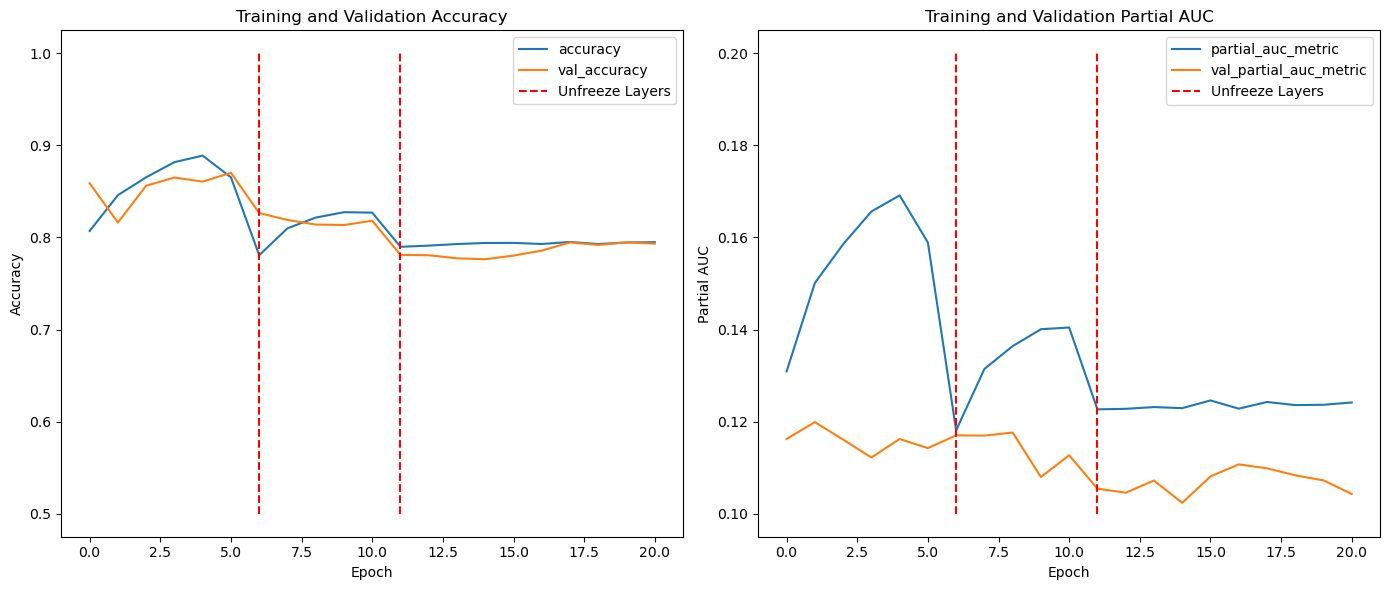

In [190]:
# Plot the training history
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(fold5_histories['accuracy'], label='accuracy')
plt.plot(fold5_histories['val_accuracy'], label='val_accuracy')
plt.vlines([6, 11], 0.5, 1, colors='r', linestyles='dashed', label='Unfreeze Layers')

plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(fold5_histories['partial_auc_metric'], label='partial_auc_metric')
plt.plot(fold5_histories['val_partial_auc_metric'], label='val_partial_auc_metric')
plt.vlines([6, 11], 0.1, 0.2, colors='r', linestyles='dashed', label='Unfreeze Layers')
plt.title('Training and Validation Partial AUC')
plt.xlabel('Epoch')
plt.ylabel('Partial AUC')
plt.legend()

plt.tight_layout()
plt.savefig('Fold5/training_history.png')

In [39]:
# Load the best model
model5 = tf.keras.models.load_model('Fold5/model_02.h5', custom_objects={'partial_auc_metric': partial_auc_metric})

In [40]:
# Make predictions on the validation set
test_loader = TestDataLoader(train_val_img, validation_df5, batch_size=32)

test_dataset = tf.data.Dataset.from_generator(
    lambda: test_loader,
    output_signature=(
        tf.TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32)
    )
)

# Estimate the number of batches in the test dataset
num_batches = len(test_loader)

# Wrap the predictions call with tqdm
predictions = []
for batch in tqdm(test_dataset, total=num_batches, desc="Predicting"):
    batch_preds = model5.predict(batch, verbose=0)
    predictions.append(batch_preds)

# Convert predictions to a single numpy array
predictions = np.concatenate(predictions, axis=0)

# Calculate the partial AUC
partial_auc = partial_auc_metric(validation_df5['target'].values, predictions)
print(f"Partial AUC: {partial_auc:.4f}")

Predicting:   0%|          | 0/244 [00:00<?, ?it/s]

2024-11-22 22:22:29.273285: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


Partial AUC: 0.1024


In [41]:
# Add predictions to the validation DataFrame
validation_df5['cnn_confidence'] = predictions

In [42]:
# Combine the validation DataFrames
validation_df = pd.concat([validation_df, validation_df2, validation_df3, validation_df4, validation_df5], axis=0)

# Save the validation DataFrame
validation_df.to_csv('metadata_with_cnn.csv', index=False)